# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [1]:
import os
import pyciemss
import torch
import pandas as pd

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

smoke_test = ('CI' in os.environ)

### Select models and data

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

### Set parameters for sampling

In [3]:
start_time = 0.0
end_time = 100.
logging_step_size = 10.0
num_samples = 3 if smoke_test else 10

## Sample interface
Take `num_samples` number of samples from the (prior) distribution invoked by the chosen model.

### Sample from model 1

timepoint_id  sample_id  persistent_beta_c_param  persistent_kappa_param  \
0             0          0                 0.703142                 0.22929   
1             1          0                 0.703142                 0.22929   
2             2          0                 0.703142                 0.22929   
3             3          0                 0.703142                 0.22929   
4             4          0                 0.703142                 0.22929   

   persistent_gamma_param  persistent_hosp_param  persistent_death_hosp_param  \
0                0.321689               0.187183                     0.075173   
1                0.321689               0.187183                     0.075173   
2                0.321689               0.187183                     0.075173   
3                0.321689               0.187183                     0.075173   
4                0.321689               0.187183                     0.075173   

   persistent_I0_param   D_state    E_state   H_state    I_state     R_state  \
0             8.890608  0.430029  17.607685  4.434499  15.699987   49.387333   
1             8.890608  1.062960  11.325868  3.701303  10.186867   90.551437   
2             8.890608  1.526424   7.311902  2.504281   6.577016  117.826996   
3             8.890608  1.833093   4.720637  1.632315   4.246198  135.528381   
4             8.890608  2.032093   3.047693  1.055941   2.741390  146.968948   

      S_state  infected_observable_state  exposed_observable_state  \
0  19339958.0                  15.699987                 17.607685   
1  19339934.0                  10.186867                 11.325868   
2  19339914.0                   6.577016                  7.311902   
3  19339896.0                   4.246198                  4.720637   
4  19339896.0                   2.741390                  3.047693   

   hospitalized_observable_state  dead_observable_state  
0                       4.434499               0.430029  
1                       3.701303               1.062960  
2                       2.504281               1.526424  
3                       1.632315               1.833093  
4                       1.055941               2.032093

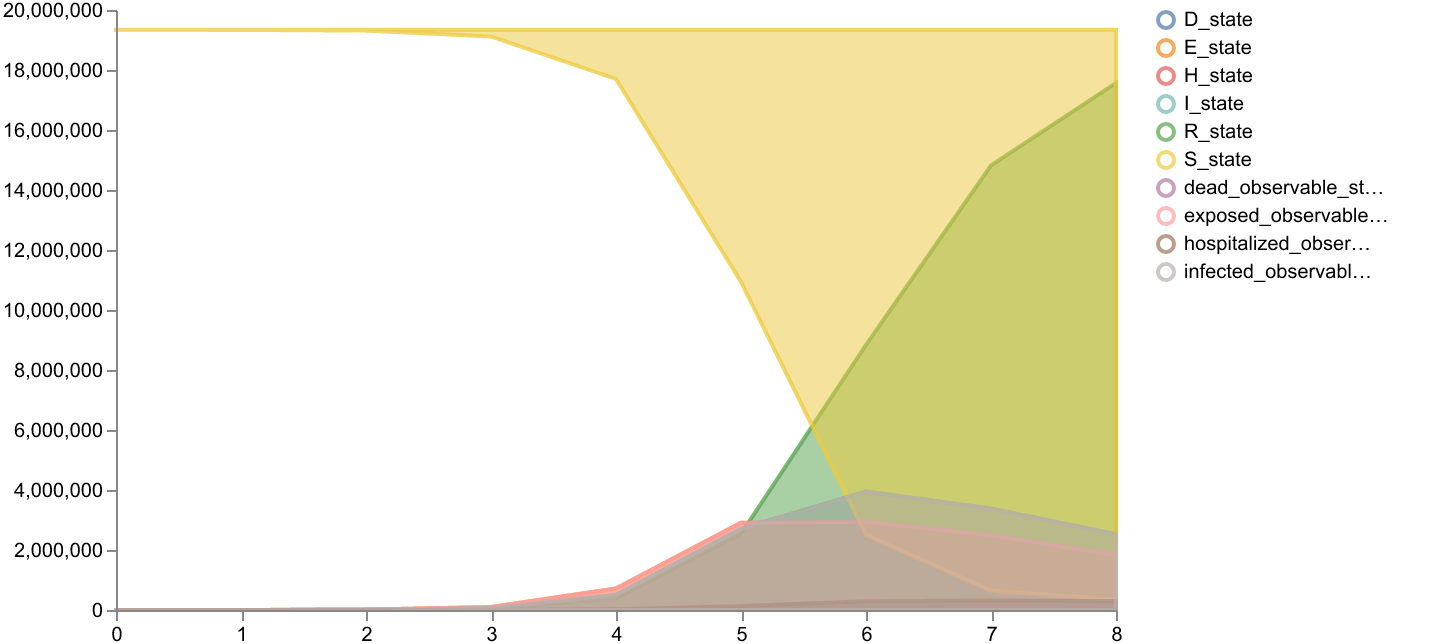

In [4]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [6]:
print(result1['risk'])

{'D_state': {'risk': [121127.6171875], 'qoi': tensor([1.0625e+04, 6.2731e+02, 8.1683e-02, 1.2593e-01, 8.5820e+02, 1.2113e+05,
        2.1491e+01, 3.5982e-01, 3.3757e-01, 2.3512e-01])}, 'E_state': {'risk': [1228947.875], 'qoi': tensor([8.9922e+05, 1.2289e+06, 1.5420e-02, 1.8697e-02, 6.2679e+04, 4.8309e+04,
        1.0792e+02, 9.2415e+00, 1.7174e-01, 2.5979e-01])}, 'H_state': {'risk': [165845.40625], 'qoi': tensor([8.2368e+04, 1.2244e+04, 3.9988e-03, 4.1241e-03, 3.8851e+03, 1.6585e+05,
        2.2353e+01, 4.3597e-01, 1.9547e-02, 2.1300e-02])}, 'I_state': {'risk': [1376941.5], 'qoi': tensor([7.5295e+05, 7.4198e+05, 2.8229e-02, 1.9389e-02, 3.4057e+04, 1.3769e+06,
        7.3386e+01, 9.2046e+00, 1.6606e-01, 6.2703e-01])}, 'R_state': {'risk': [17545170.0], 'qoi': tensor([1.6348e+06, 2.9783e+06, 9.3311e+01, 9.2953e+01, 1.5819e+05, 1.7545e+07,
        1.3546e+03, 4.0517e+02, 1.1928e+02, 1.1076e+02])}, 'S_state': {'risk': [19339950.0], 'qoi': tensor([15960049.0000, 14377931.0000, 19339948.0000,

### Sample from model 2

timepoint_id  sample_id  persistent_beta_c_param  persistent_beta_nc_param  \
0             0          0                 0.360615                  0.451466   
1             1          0                 0.360615                  0.451466   
2             2          0                 0.360615                  0.451466   
3             3          0                 0.360615                  0.451466   
4             4          0                 0.360615                  0.451466   

   persistent_kappa_param  persistent_gamma_param  persistent_hosp_param  \
0                0.721877                0.131189               0.062497   
1                0.721877                0.131189               0.062497   
2                0.721877                0.131189               0.062497   
3                0.721877                0.131189               0.062497   
4                0.721877                0.131189               0.062497   

   persistent_death_hosp_param  persistent_I0_param      D_state  \
0                     0.054488             5.711345     0.107035   
1                     0.054488             5.711345     1.464716   
2                     0.054488             5.711345    16.208187   
3                     0.054488             5.711345   174.950500   
4                     0.054488             5.711345  1775.907349   

        E_state       H_state       I_state       R_state     S_state  \
0  2.389770e+02      2.961730  1.616279e+02  7.575242e+01  19339564.0   
1  2.590212e+03     32.772335  1.752511e+03  9.202661e+02  19334746.0   
2  2.800092e+04    355.026520  1.896792e+04  1.006909e+04  19282618.0   
3  2.937924e+05   3800.029541  2.015987e+05  1.082034e+05  18732474.0   
4  2.305214e+06  36168.269531  1.792707e+06  1.062279e+06  14141901.0   

   infected_observable_state  exposed_observable_state  \
0               1.616279e+02              2.389770e+02   
1               1.752511e+03              2.590212e+03   
2               1.896792e+04              2.800092e+04   
3               2.015987e+05              2.937924e+05   
4               1.792707e+06              2.305214e+06   

   hospitalized_observable_state  dead_observable_state  
0                       2.961730               0.107035  
1                      32.772335               1.464716  
2                     355.026520              16.208187  
3                    3800.029541             174.950500  
4                   36168.269531            1775.907349

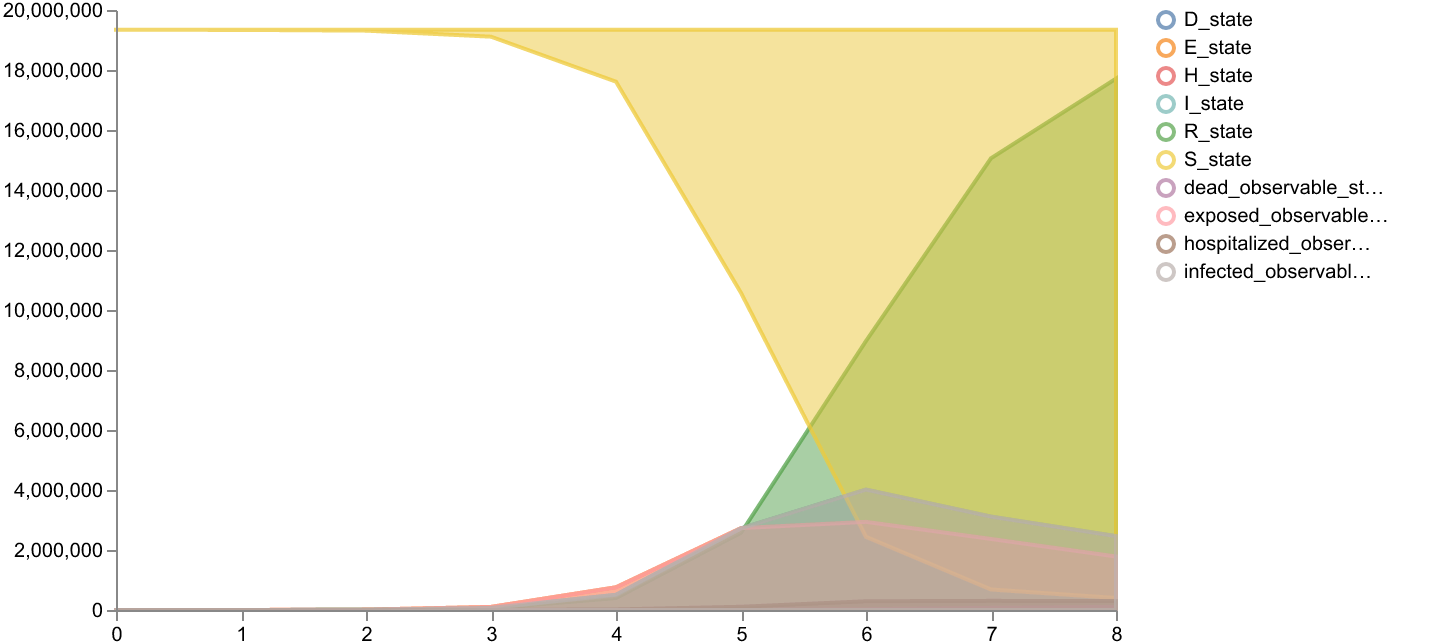

In [5]:
result2 = pyciemss.sample(model2, end_time, logging_step_size, num_samples, start_time=start_time)
display(result2['data'].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result2["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Ensemble Sample Interface
Sample from an ensemble of model 1 and model 2 

,timepoint_id,sample_id,timepoint_unknown,model_0/weight_param,model_1/weight_param,model_0/persistent_beta_c_param,model_0/persistent_kappa_param,model_0/persistent_gamma_param,model_0/persistent_hosp_param,model_0/persistent_death_hosp_param,...,D_state,E_state,H_state,I_state,R_state,S_state,infected_state,exposed_state,hospitalized_state,dead_state
0,0,0,0.737639,0.26236,0.233624,0.078811,0.33843,0.062159,0.040327,11.967278,...,0.077488,11.153106,1.062737,11.348864,50.838417,19339974.0,11.348864,11.153106,1.062737,0.077488
1,1,0,0.737639,0.26236,0.233624,0.078811,0.33843,0.062159,0.040327,11.967278,...,0.162761,5.959997,0.561738,5.540137,77.186440,19339962.0,5.540137,5.959997,0.561738,0.162761
2,2,0,0.737639,0.26236,0.233624,0.078811,0.33843,0.062159,0.040327,11.967278,...,0.211601,4.075741,0.272360,3.551054,91.651596,19339960.0,3.551054,4.075741,0.272360,0.211601
3,3,0,0.737639,0.26236,0.233624,0.078811,0.33843,0.062159,0.040327,11.967278,...,0.242001,3.077925,0.160901,2.617850,101.509438,19339944.0,2.617850,3.077925,0.160901,0.242001
4,4,0,0.737639,0.26236,0.233624,0.078811,0.33843,0.062159,0.040327,11.967278,...,0.263616,2.401534,0.112719,2.027185,108.931725,19339940.0,2.027185,2.401534,0.112719,0.263616


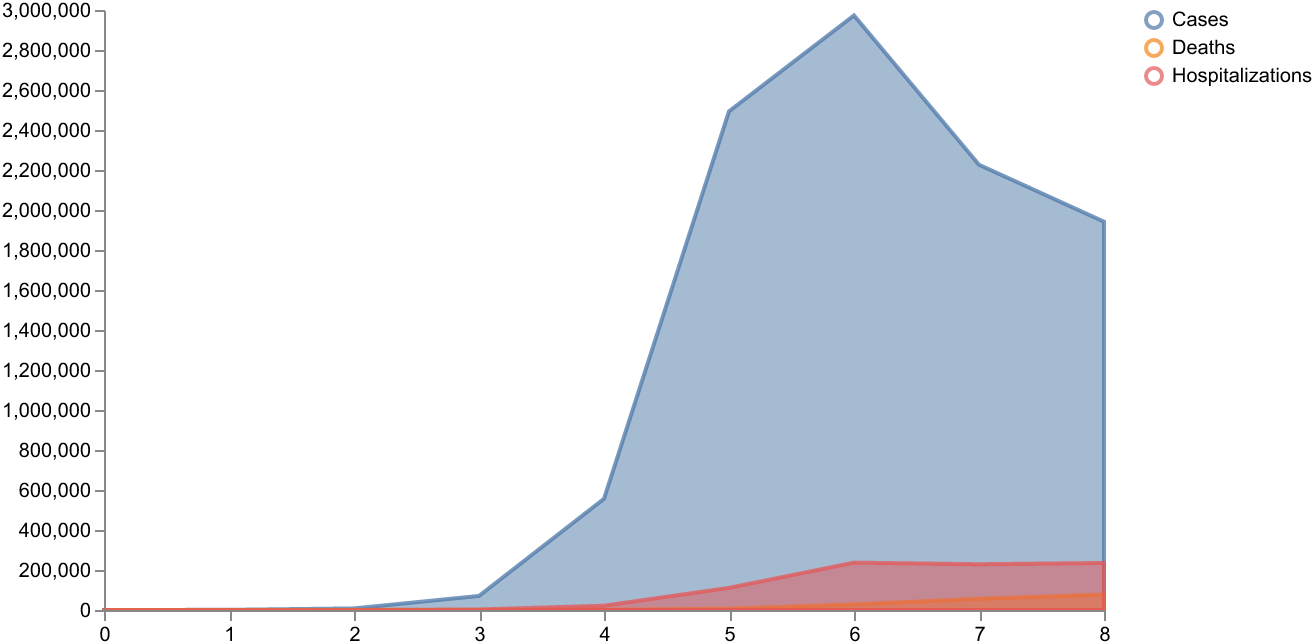

In [6]:
model_paths = [model1, model2]
solution_mappings = [lambda x : x, lambda x : x] # Conveniently, these two models operate on exactly the same state space, with the same names.

ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, logging_step_size, num_samples, start_time=start_time)
display(ensemble_result['data'].head())

# Plot the ensemble result for cases, hospitalizations, and deaths
nice_labels={"dead_state": "Deaths", 
                 "hospitalized_state": "Hospitalizations",
                 "infected_state": "Cases"
                }
schema = plots.trajectories(ensemble_result["data"], 
                           keep=["infected_state", "hospitalized_state", "dead_state"], 
                           relabel=nice_labels,
                          )
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate interface
Calibrate a model to a dataset by mapping model state varibale or observables to columns in the dataset

In [7]:
data_mapping = {"case": "I", "hosp": "H"} # data_mapping = {"column_name": "observable/state_variable"}
num_iterations = 10 if smoke_test else 1000
calibrated_results = pyciemss.calibrate(model1, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 328.9398749768734}

In [8]:
parameter_estimates()

{'persistent_beta_c': tensor(0.3531, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.5088, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.3715, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1431, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0486, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(7.9459, grad_fn=<ExpandBackward0>)}

### Use calibrated parameter estimates in `sample` to sample from the calibrated model (posterior distr.)

,timepoint_id,sample_id,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,0.433994,0.495006,0.381135,0.108386,0.067599,7.178659,0.283940,43.706329,3.894912,25.786711,70.509964,19339896.0,25.786711,43.706329,3.894912,0.283940
1,1,0,0.433994,0.495006,0.381135,0.108386,0.067599,7.178659,0.994623,66.680244,6.644840,39.371212,189.417786,19339736.0,39.371212,66.680244,6.644840,0.994623
2,2,0,0.433994,0.495006,0.381135,0.108386,0.067599,7.178659,2.120224,101.759796,10.235750,60.084194,371.458527,19339486.0,60.084194,101.759796,10.235750,2.120224
3,3,0,0.433994,0.495006,0.381135,0.108386,0.067599,7.178659,3.843539,155.289841,15.633397,91.691750,649.343933,19339154.0,91.691750,155.289841,15.633397,3.843539
4,4,0,0.433994,0.495006,0.381135,0.108386,0.067599,7.178659,6.474165,236.968918,23.858574,139.921173,1073.413086,19338560.0,139.921173,236.968918,23.858574,6.474165


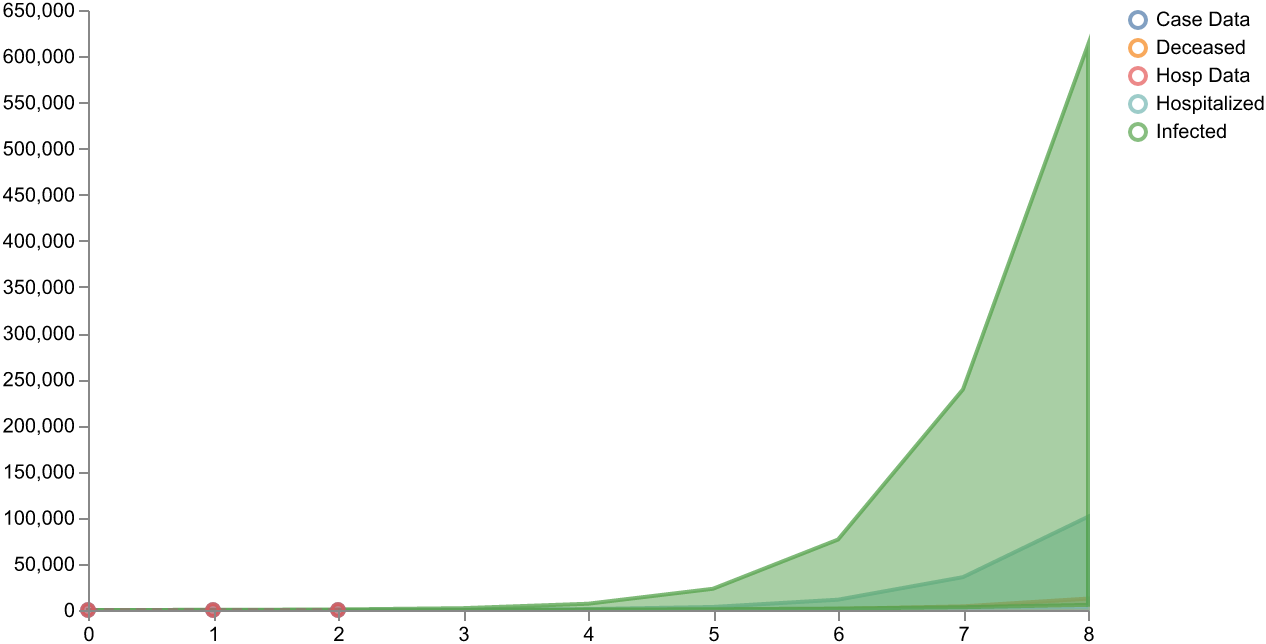

In [9]:
calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "dead_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data",
        "hosp": "Hosp Data"
        }
data_df = pd.read_csv(dataset1)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "dead_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static parameter intervention
Change the value of the parameter `p_cbeta` to 0.5 on day 1

,timepoint_id,sample_id,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,0.308847,13.354735,1.263146,0.084350,999.653320
1,1,0,0.308847,13.354735,1.930675,0.202167,998.869385
2,2,0,0.308847,13.354735,2.949535,0.382205,997.668396
3,3,0,0.308847,13.354735,4.502709,0.657150,995.841003
4,4,0,0.308847,13.354735,6.865966,1.076638,993.058777


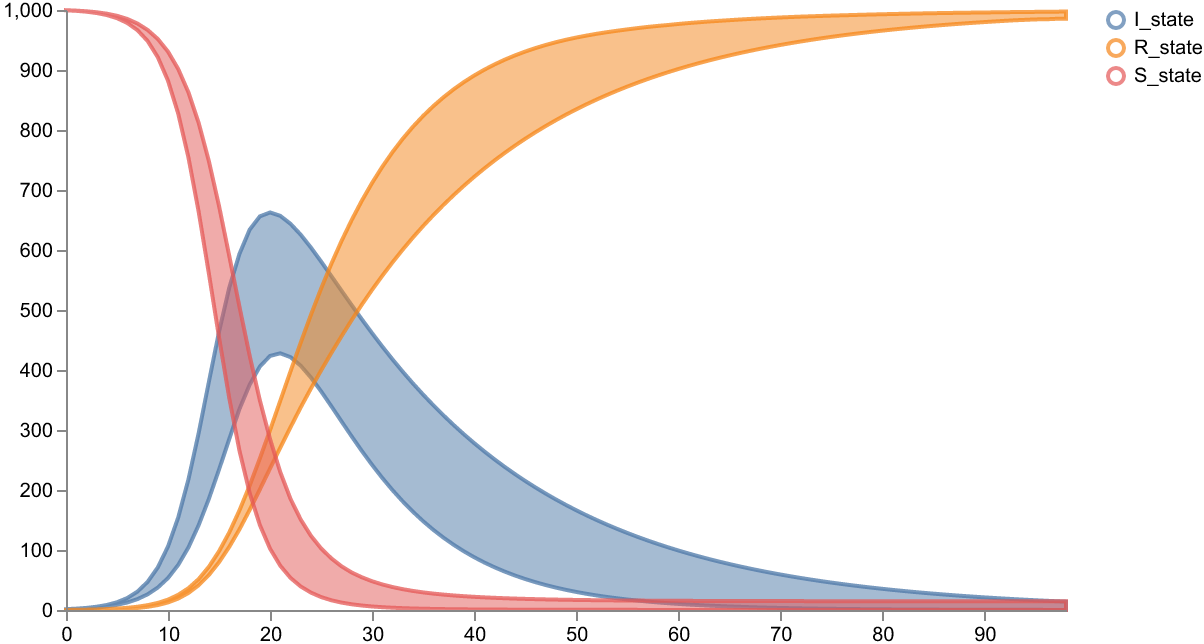

In [11]:
start_time = 0.0
end_time = 100.0
logging_step_size = 1.0
num_samples = 5 if smoke_test else 100

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(1.): {"p_cbeta": torch.tensor(0.5)}})
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static state intervention
Change the Infected state `I` to 20.0 on day 5

timepoint_id  sample_id  persistent_p_cbeta_param  persistent_p_tr_param  \
0             0          0                  0.372911              19.221806   
1             1          0                  0.372911              19.221806   
2             2          0                  0.372911              19.221806   
3             3          0                  0.372911              19.221806   
4             4          0                  0.372911              19.221806   

    I_state   R_state     S_state  
0  1.377731  0.061327  999.561890  
1  1.897774  0.145810  998.956360  
2  2.613423  0.262168  998.124390  
3  3.597629  0.422375  996.980103  
4  4.949997  0.642860  995.407288

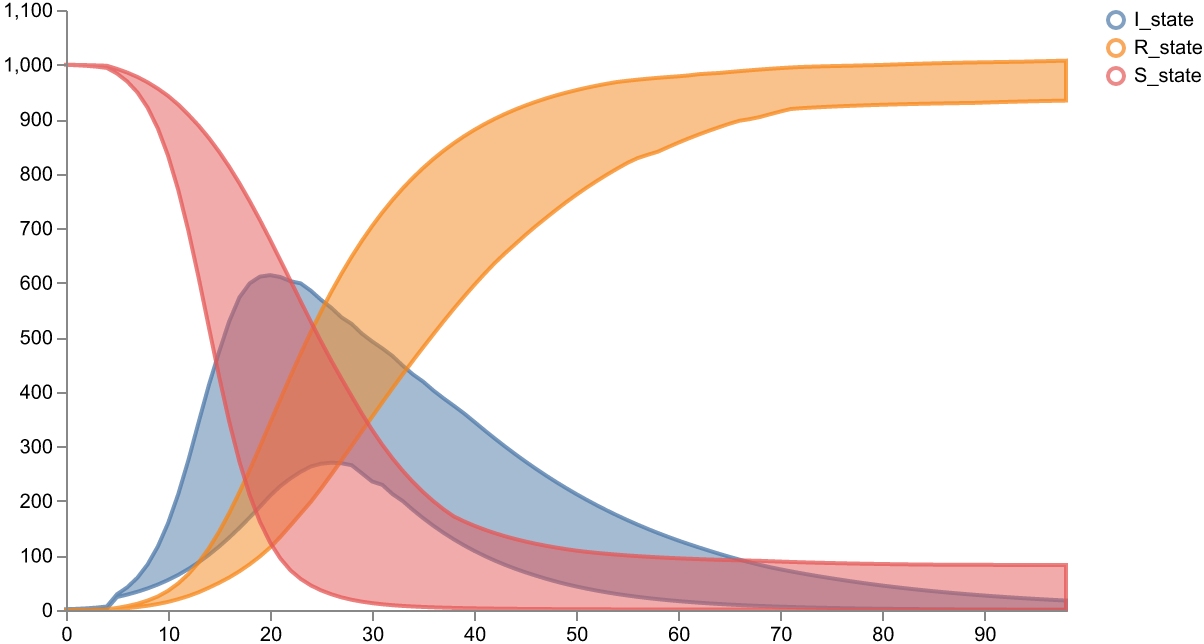

In [13]:
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_state_interventions={torch.tensor(5.): {"I": torch.tensor(20.0)}}, solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with dynamic parameter interventions
Change the parameter `p_cbeta` from 0.35 to 0.3 when the infectious population `I` exceeds 400.

,timepoint_id,sample_id,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,0.252528,12.308774,1.186489,0.088603,999.723877
1,1,0,0.252528,12.308774,1.407651,0.193726,999.398682
2,2,0,0.252528,12.308774,1.669886,0.318437,999.011658
3,3,0,0.252528,12.308774,1.980762,0.466374,998.552795
4,4,0,0.252528,12.308774,2.349220,0.641841,998.008972


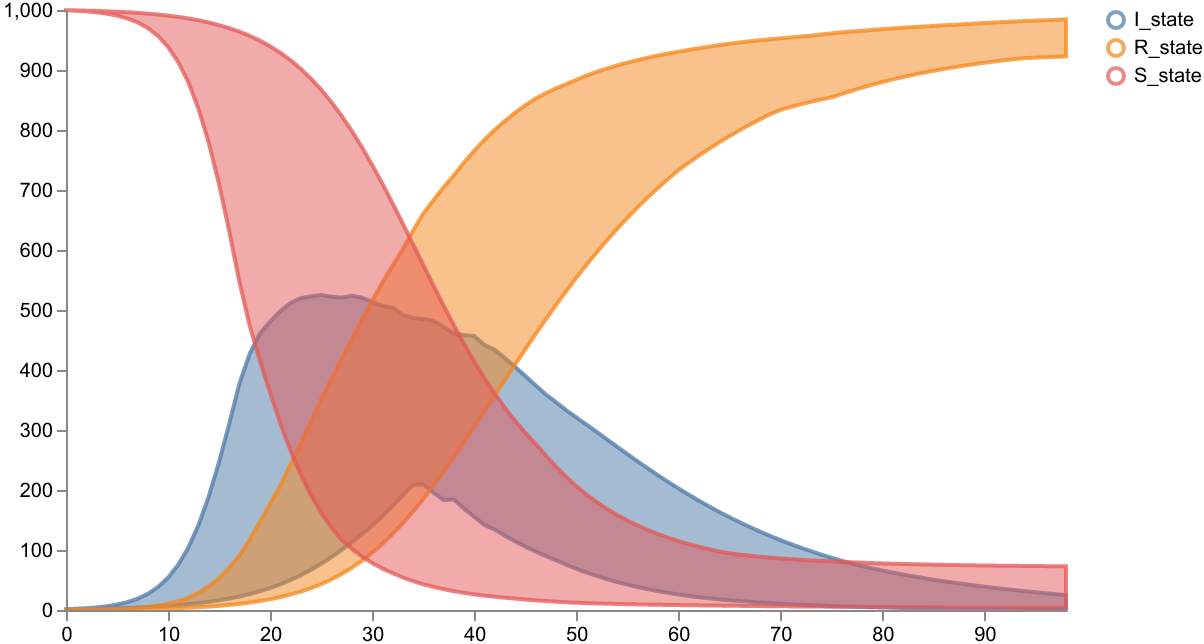

In [13]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    return lambda time, state: state[var] - threshold  
    
infection_threshold = make_var_threshold("I", torch.tensor(400.0))
dynamic_parameter_interventions1 = {infection_threshold: {"p_cbeta": torch.tensor(0.3)}}

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_parameter_interventions=dynamic_parameter_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [ ]:
# # NOTE: If you change the solver to "euler", you need to specify the step size in `solver_options` as below:
# # Specify solver options including the step_size
# solver_options = {"step_size": 1e-2}  # Example step size, adjust as needed
# result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
#                          dynamic_parameter_interventions=dynamic_parameter_interventions1, 
#                          solver_method="euler",
#                          solver_options=solver_options)

## Sample interface with dynamic state interventions
Reduce the susceptible population `S` to 200.0 when infections `I` exceed 400. 

In [ ]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    return lambda time, state: state[var] - threshold  
    
infection_threshold = make_var_threshold("I", torch.tensor(400.0))
dynamic_state_interventions1 = {infection_threshold: {"S": torch.tensor(200.0)}} 

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_state_interventions=dynamic_state_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface
Get infections below 300 individuals at 100 days for SIR model with minimum change to current value for intervention parameter

In [ ]:
import numpy as np
from typing import Dict, List

def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()

    return np.mean(dataQoI[:, -ndays:], axis=1)

start_time = 0.0
end_time = 40.
logging_step_size = 1.0
observed_params = ["I_state"]
intervention_time = torch.tensor(1.)
intervened_params = "p_cbeta"
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]

risk_bound = 300.
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current-x)
static_parameter_interventions = {intervention_time: intervened_params}

opt_result = pyciemss.optimize(model3, end_time, logging_step_size, qoi, risk_bound, static_parameter_interventions, objfun, 
                               initial_guess_interventions=initial_guess_interventions, bounds_interventions=bounds_interventions, 
                               start_time=0.0, n_samples_ouu=int(1e2), maxiter=1, maxfeval=20, solver_method="euler")
print(f'Optimal policy for intervening on {static_parameter_interventions[list(static_parameter_interventions.keys())[0]]} is ', opt_result["policy"])

#### Sample using optimal policy as intervention

In [ ]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={intervention_time: {intervened_params: opt_result["policy"]}}, 
                         solver_method="euler")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)